In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import jax
import jax.numpy as jnp
import scipy.stats as stats
import math
import csv
#from jax import grad, jit, devices
#import autograd.numpy as jnp
#from autograd import grad

In [2]:
def func_resize(img, size):
    nR, nC = size
    nR0 = len(img)     # source number of rows 
    nC0 = len(img[0])  # source number of columns 
    return [[ img[int(nR0 * r / nR)][int(nC0 * c / nC)]
             for c in range(nC)] for r in range(nR)]

In [3]:
def func_reshape(image, max_size):
    p = len(image)
    if p < max_size:
        image = np.hstack((np.zeros((p,(max_size-p)//2)), image, np.zeros((p,(max_size-p)//2))))
        image = np.vstack((np.zeros(((max_size-p)//2,max_size)), image, np.zeros(((max_size-p)//2,max_size))))
    return image

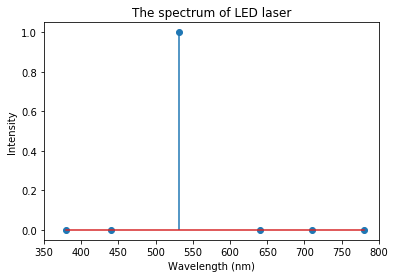

In [4]:
lam_x = np.array([0.380, 0.440, 0.532, 0.640, 0.710, 0.780])
# inten_x = np.array([0.2, 0.4, 1, 0.4, 0.3, 0.2])
inten_x = np.array([0, 0, 1, 0, 0, 0])

max_index = inten_x.argmax()
lam_depth = len(lam_x)

lam = lam_x[max_index]

plt.stem(lam_x*1.0e3, inten_x, use_line_collection=True)
plt.xlim(350,800)
plt.title('The spectrum of LED laser')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()

target image size:  2048 x 2048


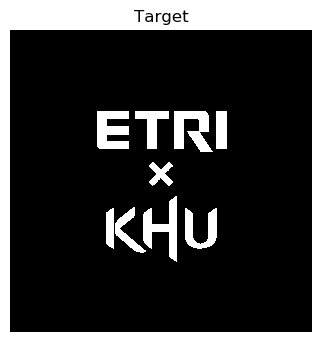

In [5]:
%matplotlib inline

logo = plt.imread('EK_1616x1616.png')[:,:,0]
ll, mm = 1616, 2048

logo = (logo>0.5)*1

logo = np.hstack((np.zeros((ll,(mm-ll)//2)),logo,np.zeros((ll,(mm-ll)//2))))
logo = np.vstack((np.zeros(((mm-ll)//2,mm)),logo,np.zeros(((mm-ll)//2,mm))))

# logo = logo[::16,::16]
# logo = np.kron(logo, np.ones((2,2)))
logo = logo.astype(np.int8)

p = logo.shape[0]                # pxp target image
m = p*p                          # number of pixels in target image
m_b = int(np.sum(logo))          # number of bright pixels
m_d = m - m_b                    # number of dark pixels

target_coords = np.where( logo > 0 ) 

target = logo#.flatten()
print("target image size: ",p,"x",p)
plt.figure(dpi=100, figsize=(4,4))
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.show()

d_n = 0.6                        # Refractive index of Photoresist : 1.6
q   = int(1.0*p)
d   = 2.0                        # pitch: 2 micrometer
f   = p/lam*4

max_size = int(p*lam_x[-1]/lam)
max_size += max_size%2

# list of SLM pixels contained in the pupil
slm_x, slm_y = np.meshgrid( np.arange(q), np.arange(q) )
slm_x = ( slm_x - int(q/2) ) * d
slm_y = ( slm_y - int(q/2) ) * d
slm_x = slm_x.astype(np.float32)
slm_y = slm_y.astype(np.float32)

# quad_phase = np.zeros((q,q,), dtype=np.complex64)
# quad_phase = np.exp(1j*np.pi/(lam*f)*( slm_x**2 + slm_y**2 ))

pup_ind = np.kron(range(q),np.ones(q,dtype=np.int8)), \
          np.kron(np.ones(q,dtype=np.int8),range(q))

n = pup_ind[0].shape[0]

SLM_size = d*q         # in um
IMG_size = lam*f/d     # in um
IMG_pitch = IMG_size/p # in um

In [6]:
lam_depth = lam_x.size
quad_phase_3d = np.zeros((q,q,lam_depth), dtype=np.complex64)
for i in range(lam_depth):
    quad_phase_3d[:,:,i] = np.exp(1j*np.pi/(lam_x[i]*f)*( slm_x**2 + slm_y**2 ))
    
print('lam_depth :',lam_depth)

lam_depth : 6


In [7]:
filename_1 = 'LC_d_ls_1_%dx%d' %(p,p)
LC_d_ls_1 = np.loadtxt(filename_1+'.csv', dtype=np.float32)

intensity_ls_1 = np.zeros((max_size,max_size), dtype=np.float32)

for i in range(lam_depth):
    phase_ls_1 = LC_d_ls_1*2*np.pi*d_n/lam_x[i]
    xxx = np.exp(1j*phase_ls_1)*quad_phase_3d[:,:,i]
    zzz = inten_x[i]*np.exp(1j*2*np.pi*f/lam_x[i])/(1j*lam_x[i]*f)*np.fft.fft2(xxx)/n
    img_size = int(p*lam_x[i]/lam)
    img_size += img_size%2
    zzz = func_resize(zzz, (img_size, img_size))
    zzz = func_reshape(zzz, max_size)
    intensity_ls_1 += np.abs(zzz)**2
del xxx, zzz

print('LS_1')

LS_1


In [8]:
filename_2 = 'LC_d_ls_2_%dx%d' %(p,p)
LC_d_ls_2 = np.loadtxt(filename_2+'.csv', dtype=np.float32)

intensity_ls_2 = np.zeros((max_size,max_size), dtype=np.float32)

for i in range(lam_depth):
    phase_ls_2 = LC_d_ls_2*2*np.pi*d_n/lam_x[i]
    xxx = np.exp(1j*phase_ls_2)*quad_phase_3d[:,:,i]
    zzz = inten_x[i]*np.exp(1j*2*np.pi*f/lam_x[i])/(1j*lam_x[i]*f)*np.fft.fft2(xxx)/n
    img_size = int(p*lam_x[i]/lam)
    img_size += img_size%2
    zzz = func_resize(zzz, (img_size, img_size))
    zzz = func_reshape(zzz, max_size)
    intensity_ls_2 += np.abs(zzz)**2
del xxx, zzz

print('LS_2')

LS_2


In [9]:
filename_3 = 'LC_d_ls_3_%dx%d' %(p,p)
LC_d_ls_3 = np.loadtxt(filename_3+'.csv', dtype=np.float32)

intensity_ls_3 = np.zeros((max_size,max_size), dtype=np.float32)
for i in range(lam_depth):
    phase_ls_3 = LC_d_ls_3*2*np.pi*d_n/lam_x[i]
    xxx = np.exp(1j*phase_ls_3)*quad_phase_3d[:,:,i]
    zzz = inten_x[i]*np.exp(1j*2*np.pi*f/lam_x[i])/(1j*lam_x[i]*f)*np.fft.fft2(xxx)/n
    img_size = int(p*lam_x[i]/lam)
    img_size += img_size%2
    zzz = func_resize(zzz, (img_size, img_size))
    zzz = func_reshape(zzz, max_size)
    intensity_ls_3 += np.abs(zzz)**2
del phase_ls_3, xxx, zzz

print('LS_3')

LS_3


# 여러 파장에 대한 실험 결과

Maximum intensity (LS_1):  4.8084075e-14
Maximum intensity (LS_2):  4.7470603e-14
Maximum intensity (LS_3):  5.3351163e-14

Minimum intensity (LS_1):  0.0
Minimum intensity (LS_2):  0.0
Minimum intensity (LS_3):  0.0


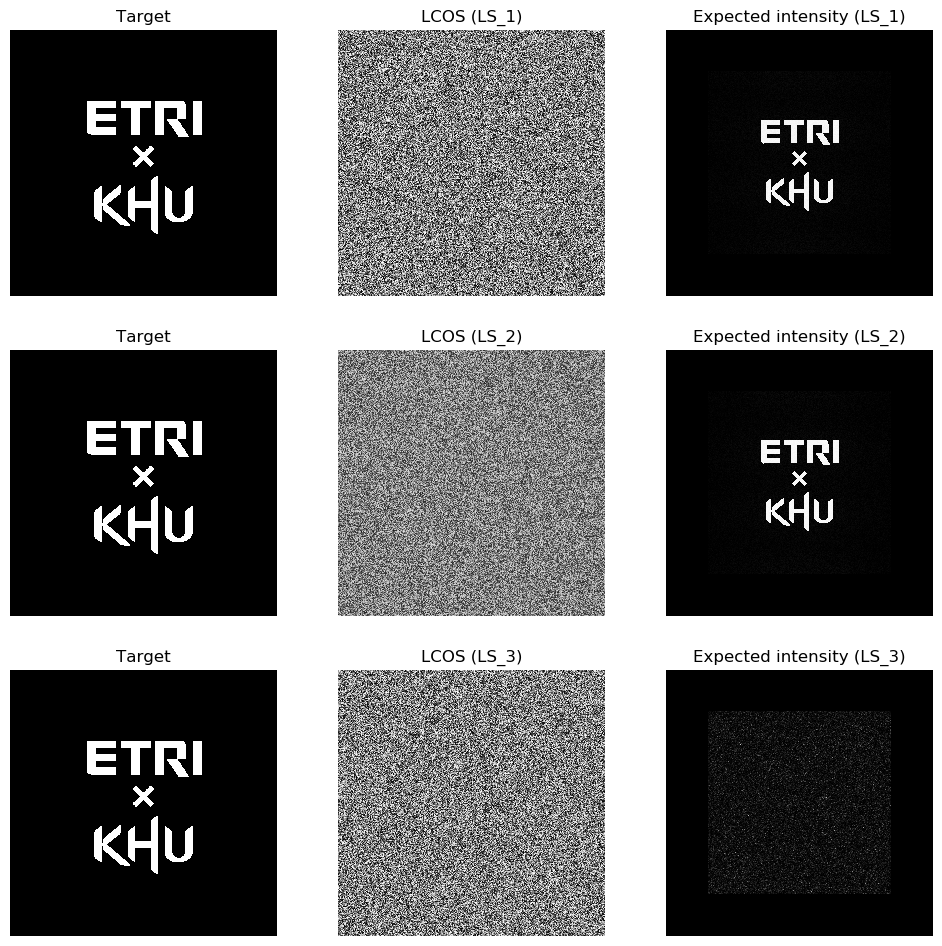

In [10]:
print("Maximum intensity (LS_1): ",intensity_ls_1.max())
print("Maximum intensity (LS_2): ",intensity_ls_2.max())
print("Maximum intensity (LS_3): ",intensity_ls_3.max())
print("")
print("Minimum intensity (LS_1): ",intensity_ls_1.min())
print("Minimum intensity (LS_2): ",intensity_ls_2.min())
print("Minimum intensity (LS_3): ",intensity_ls_3.min())

plt.figure(dpi=100, figsize=(12,12))

plt.subplot(331)
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.subplot(332)
plt.imshow(LC_d_ls_1, cmap='gray')
plt.axis('off')
plt.title('LCOS (LS_1)')
plt.subplot(333)
plt.imshow(intensity_ls_1, cmap='gray')
plt.axis('off')
plt.title('Expected intensity (LS_1)')

plt.subplot(334)
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.subplot(335)
plt.imshow(LC_d_ls_2, cmap='gray')
plt.axis('off')
plt.title('LCOS (LS_2)')
plt.subplot(336)
plt.imshow(intensity_ls_2, cmap='gray')
plt.axis('off')
plt.title('Expected intensity (LS_2)')

plt.subplot(337)
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.subplot(338)
plt.imshow(LC_d_ls_3, cmap='gray')
plt.axis('off')
plt.title('LCOS (LS_3)')
plt.subplot(339)
plt.imshow(intensity_ls_3, cmap='gray')
plt.axis('off')
plt.title('Expected intensity (LS_3)')

plt.show()

# 단일 파장에 대한 실험 결과

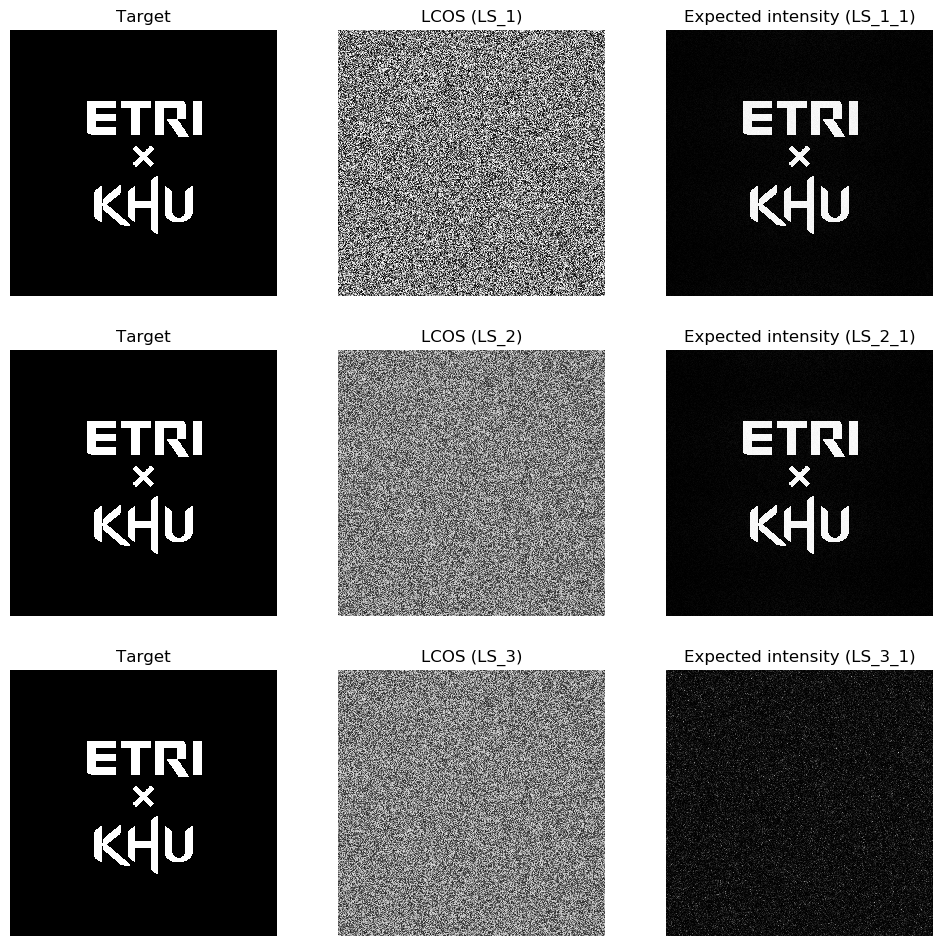

In [11]:
lam = 0.532

quad_phase_3d = np.zeros((q,q,lam_depth), dtype=np.complex64)
quad_phase_3d = np.exp(1j*np.pi/(lam*f)*( slm_x**2 + slm_y**2 ))

phase_ls_1 = LC_d_ls_1*2*np.pi*d_n/lam
xxx = np.exp(1j*phase_ls_1)*quad_phase_3d
zzz = np.fft.fft2(xxx)/n
intensity_ls_1_1 = np.abs(zzz)**2

phase_ls_2 = LC_d_ls_2*2*np.pi*d_n/lam
xxx = np.exp(1j*phase_ls_2)*quad_phase_3d
zzz = np.fft.fft2(xxx)/n
intensity_ls_2_1 = np.abs(zzz)**2

phase_ls_3 = LC_d_ls_3*2*np.pi*d_n/lam
xxx = np.exp(1j*phase_ls_3)*quad_phase_3d
zzz = np.fft.fft2(xxx)/n
intensity_ls_3_1 = np.abs(zzz)**2

del phase_ls_1, phase_ls_2, phase_ls_3, xxx, zzz

plt.figure(dpi=100, figsize=(12,12))

plt.subplot(331)
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.subplot(332)
plt.imshow(LC_d_ls_1, cmap='gray')
plt.axis('off')
plt.title('LCOS (LS_1)')
plt.subplot(333)
plt.imshow(intensity_ls_1_1, cmap='gray')
plt.axis('off')
plt.title('Expected intensity (LS_1_1)')

plt.subplot(334)
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.subplot(335)
plt.imshow(LC_d_ls_2, cmap='gray')
plt.axis('off')
plt.title('LCOS (LS_2)')
plt.subplot(336)
plt.imshow(intensity_ls_2_1, cmap='gray')
plt.axis('off')
plt.title('Expected intensity (LS_2_1)')

plt.subplot(337)
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.subplot(338)
plt.imshow(LC_d_ls_2, cmap='gray')
plt.axis('off')
plt.title('LCOS (LS_3)')
plt.subplot(339)
plt.imshow(intensity_ls_3_1, cmap='gray')
plt.axis('off')
plt.title('Expected intensity (LS_3_1)')

plt.show()

# 여러 파장에 대한 실험 결과(Histogram)

Maximum intensity (LS_1):  3.2268677205757323e-06
Maximum intensity (LS_2):  3.1856981742491037e-06
Maximum intensity (LS_3):  3.5803358372221112e-06

Minimum intensity (LS_1):  8.090562269458955e-15
Minimum intensity (LS_2):  2.2429492295543234e-14
Minimum intensity (LS_3):  7.050640291016042e-14


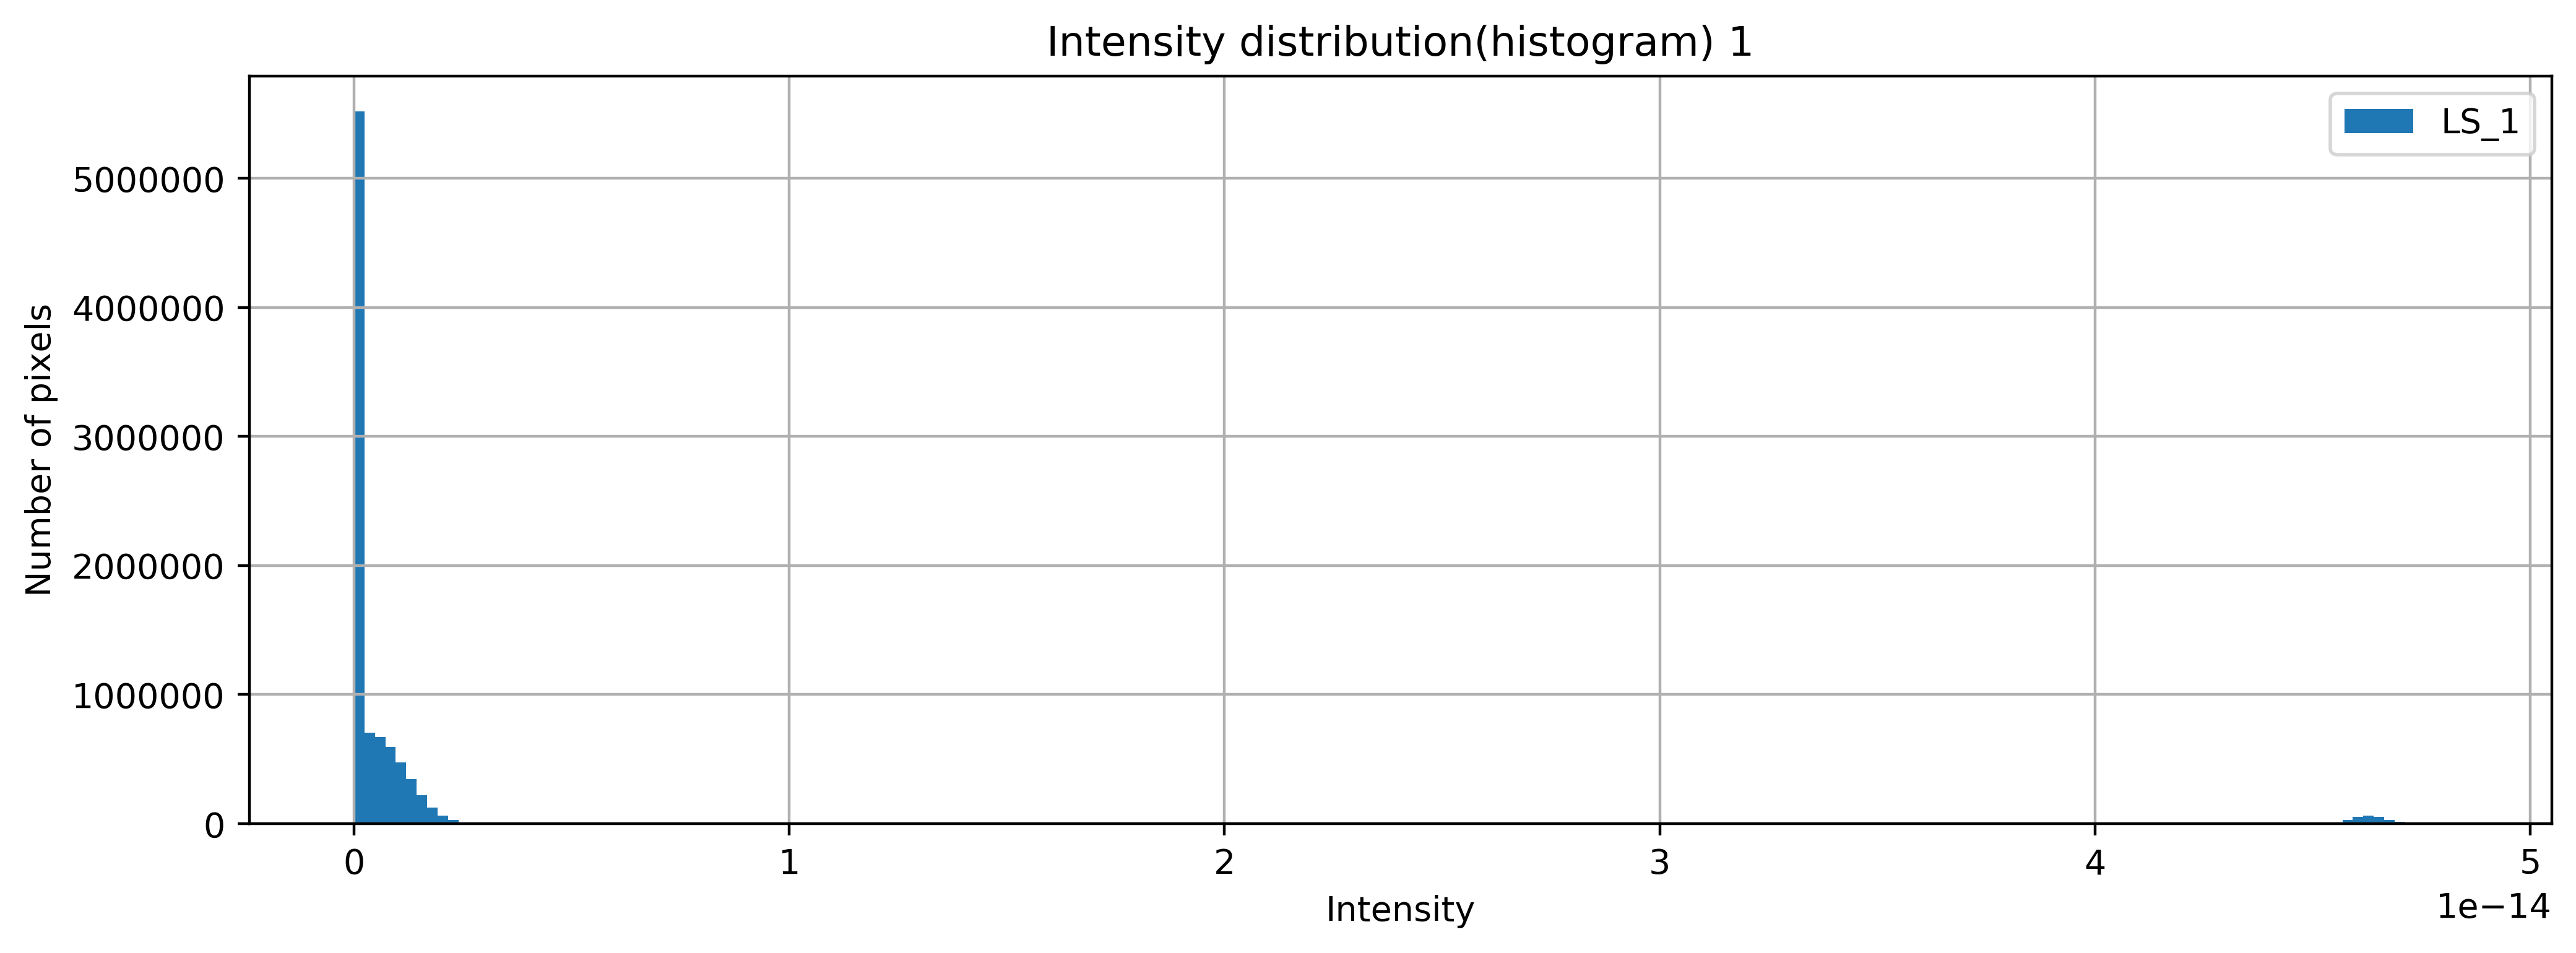

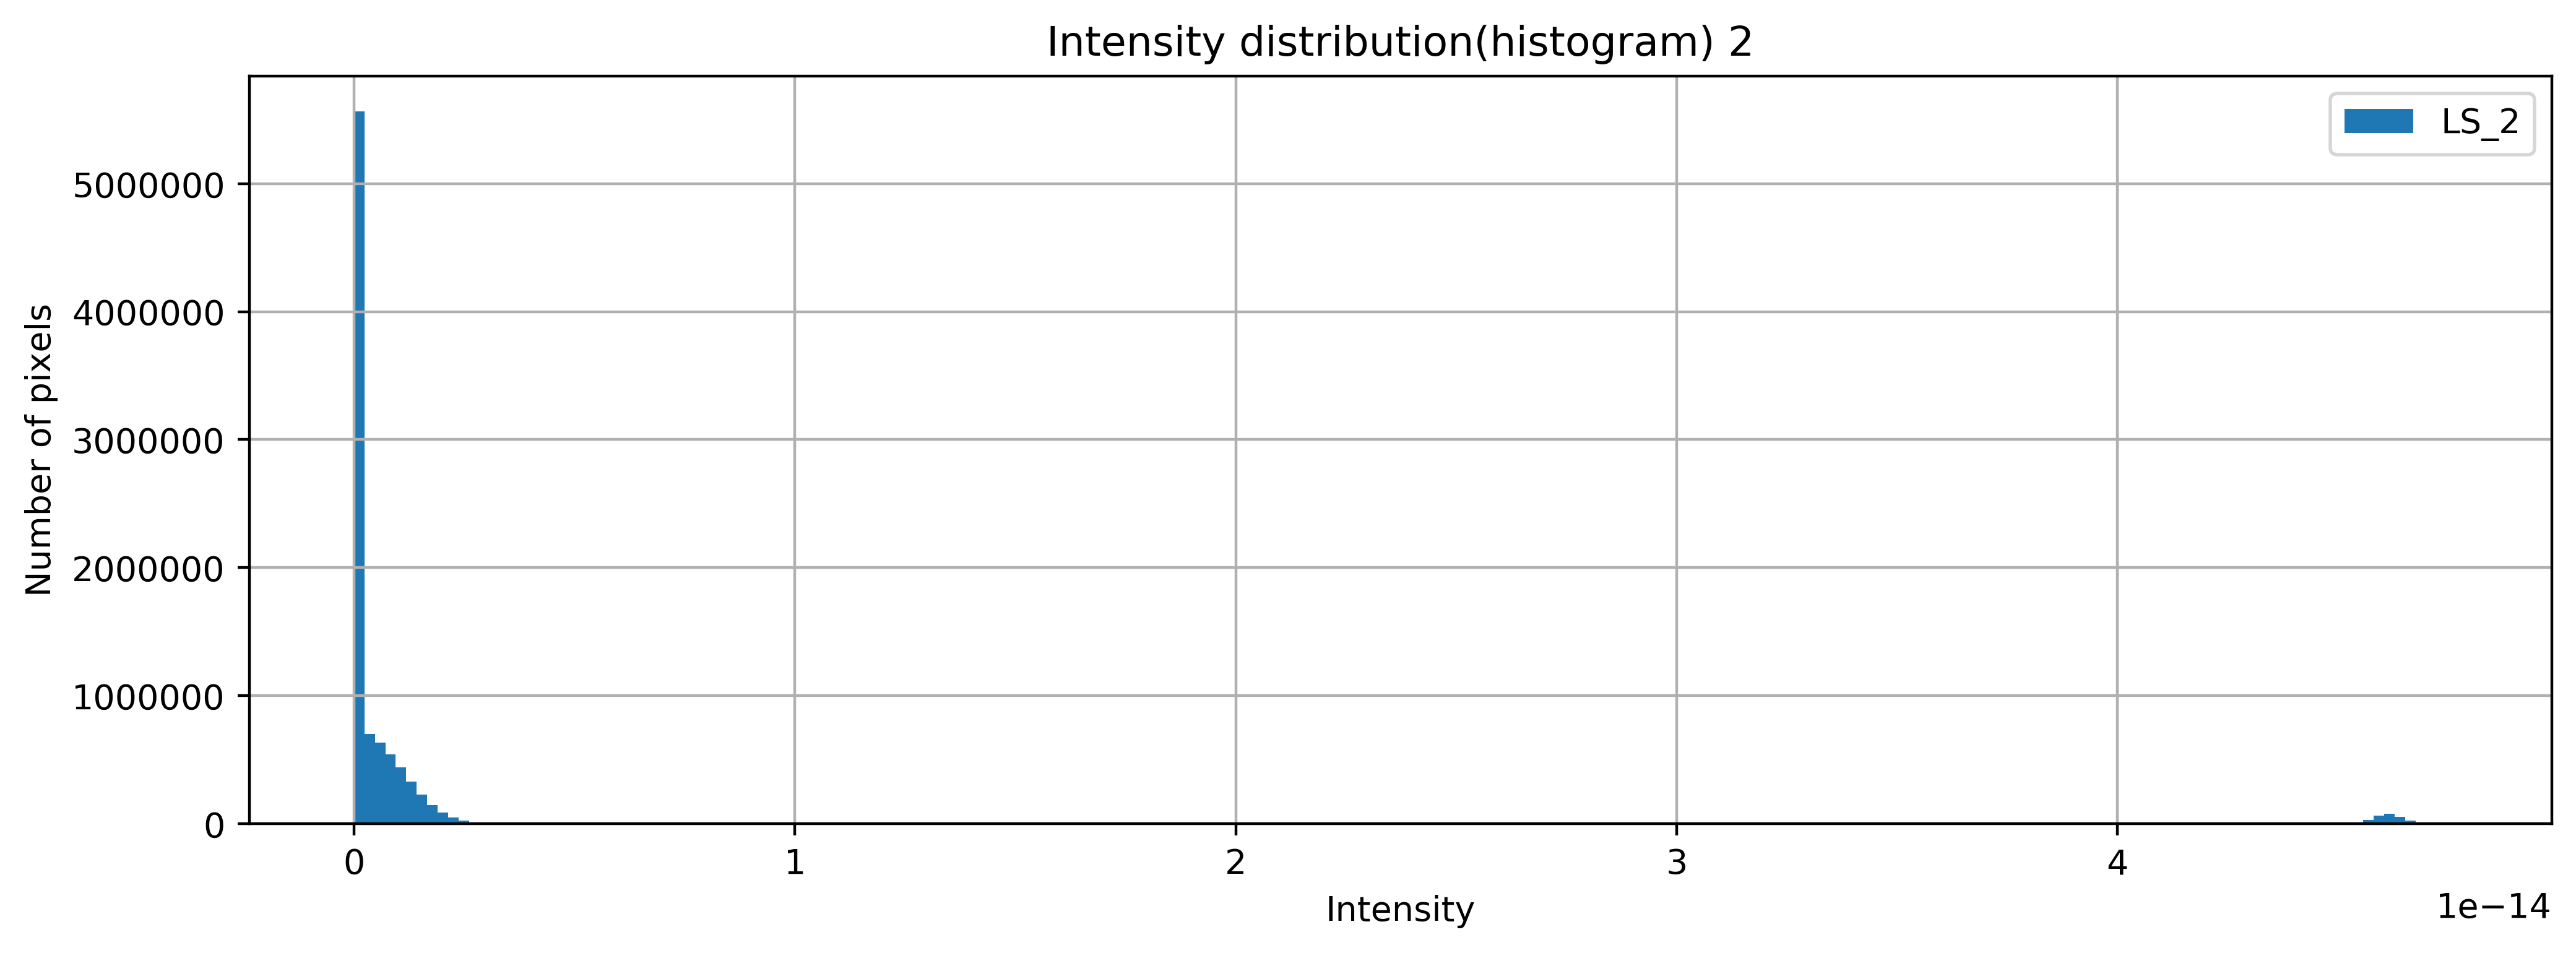

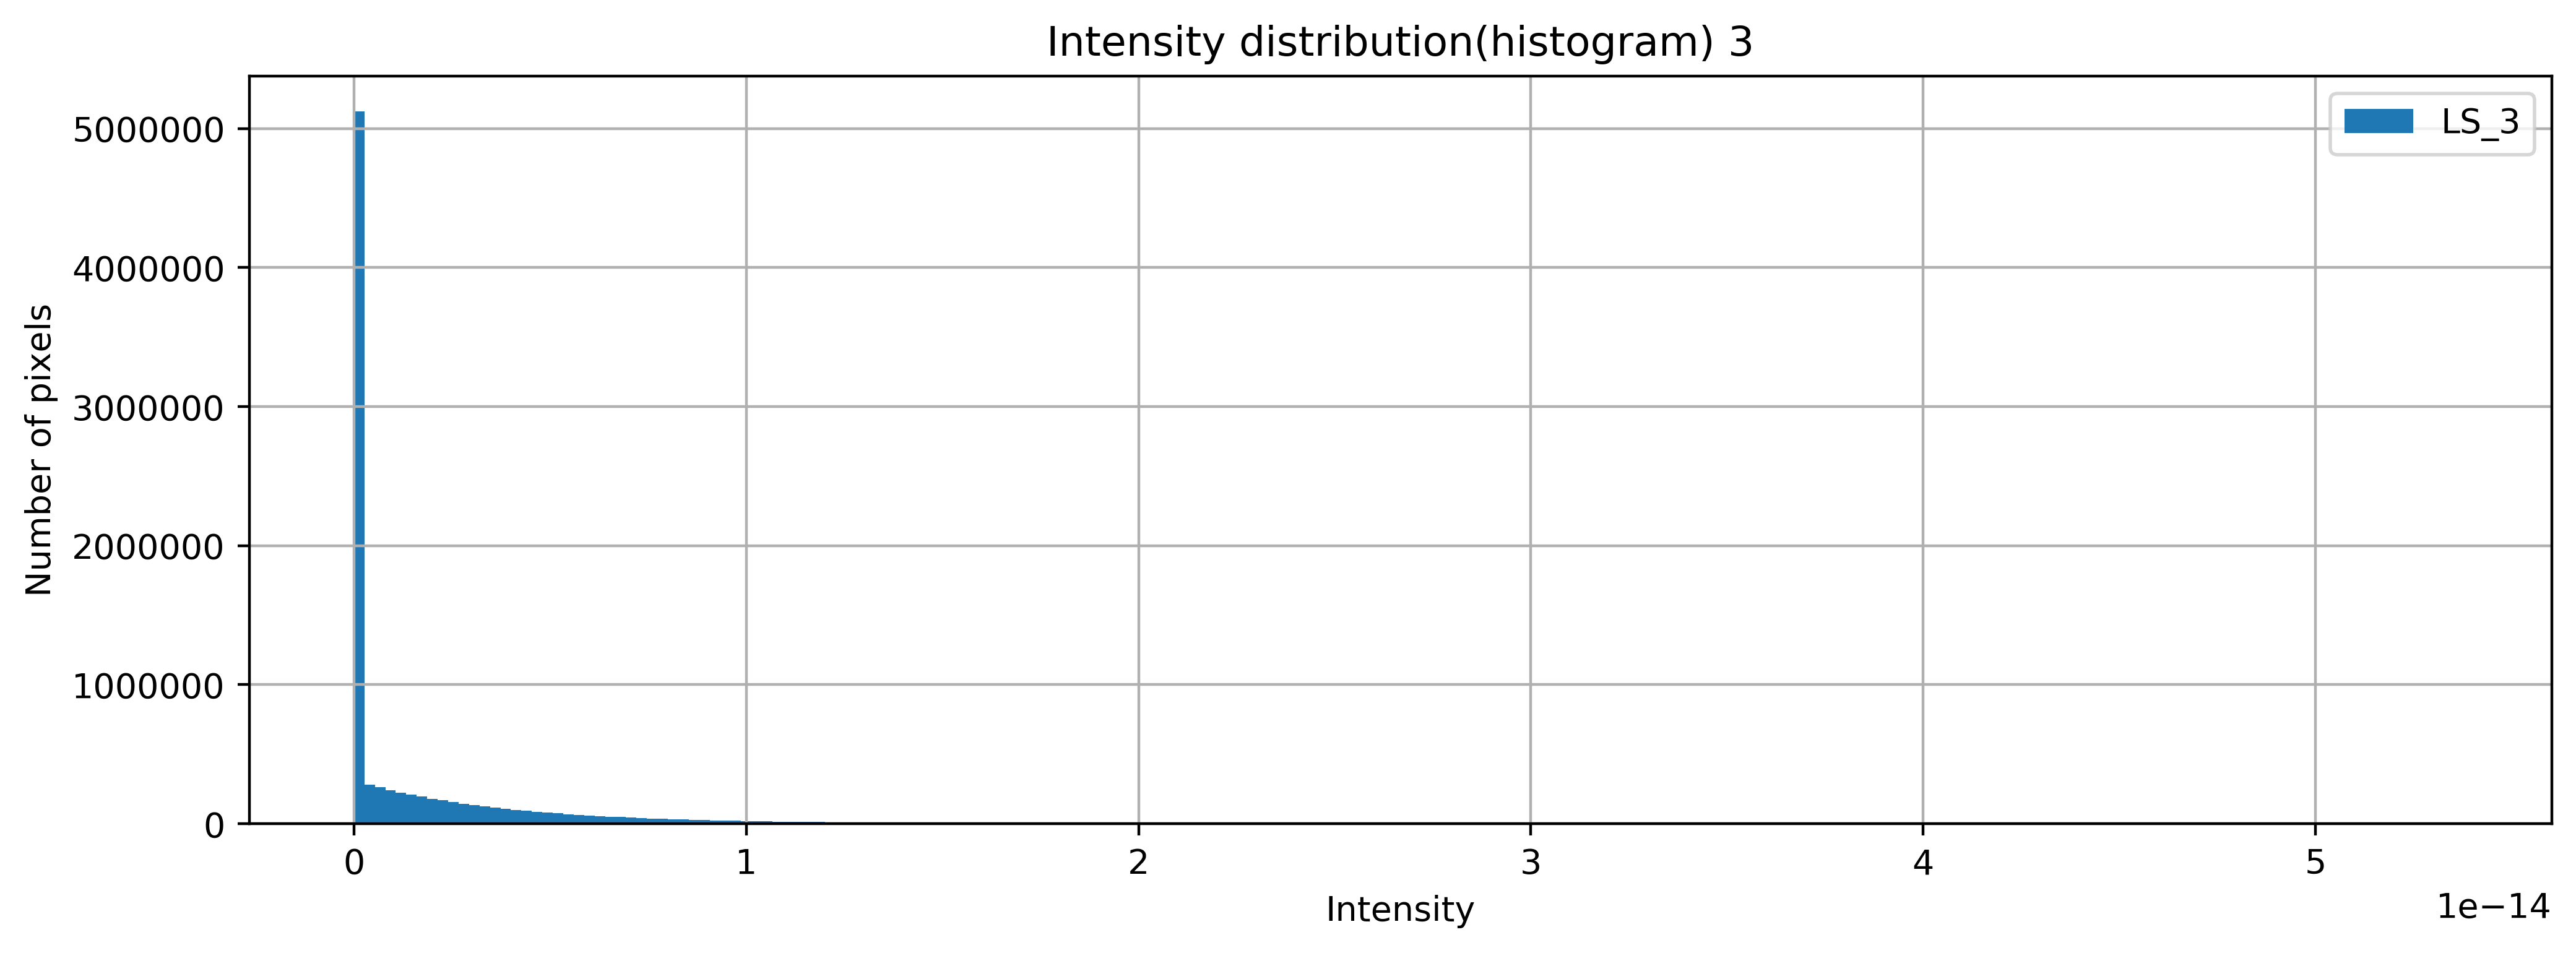

In [12]:
print("Maximum intensity (LS_1): ",intensity_ls_1_1.max())
print("Maximum intensity (LS_2): ",intensity_ls_2_1.max())
print("Maximum intensity (LS_3): ",intensity_ls_3_1.max())
print("")
print("Minimum intensity (LS_1): ",intensity_ls_1_1.min())
print("Minimum intensity (LS_2): ",intensity_ls_2_1.min())
print("Minimum intensity (LS_3): ",intensity_ls_3_1.min())

plt.figure(dpi=400, figsize=(12,4))
plt.hist(intensity_ls_1.flatten(),200,label='LS_1')
# plt.xlim(0,4e-07)
plt.title('Intensity distribution(histogram) 1')
plt.xlabel('Intensity')
plt.ylabel('Number of pixels')
plt.legend()
plt.grid()
plt.show()

plt.figure(dpi=400, figsize=(12,4))
plt.hist(intensity_ls_2.flatten(),200,label='LS_2')
# plt.xlim(0,4e-07)
plt.title('Intensity distribution(histogram) 2')
plt.xlabel('Intensity')
plt.ylabel('Number of pixels')
plt.legend()
plt.grid()
plt.show()

plt.figure(dpi=400, figsize=(12,4))
plt.hist(intensity_ls_3.flatten(),200,label='LS_3')
# plt.xlim(0,4e-07)
plt.title('Intensity distribution(histogram) 3')
plt.xlabel('Intensity')
plt.ylabel('Number of pixels')
plt.legend()
plt.grid()
plt.show()

# 단일 파장에 대한 실험 결과(Histogram)

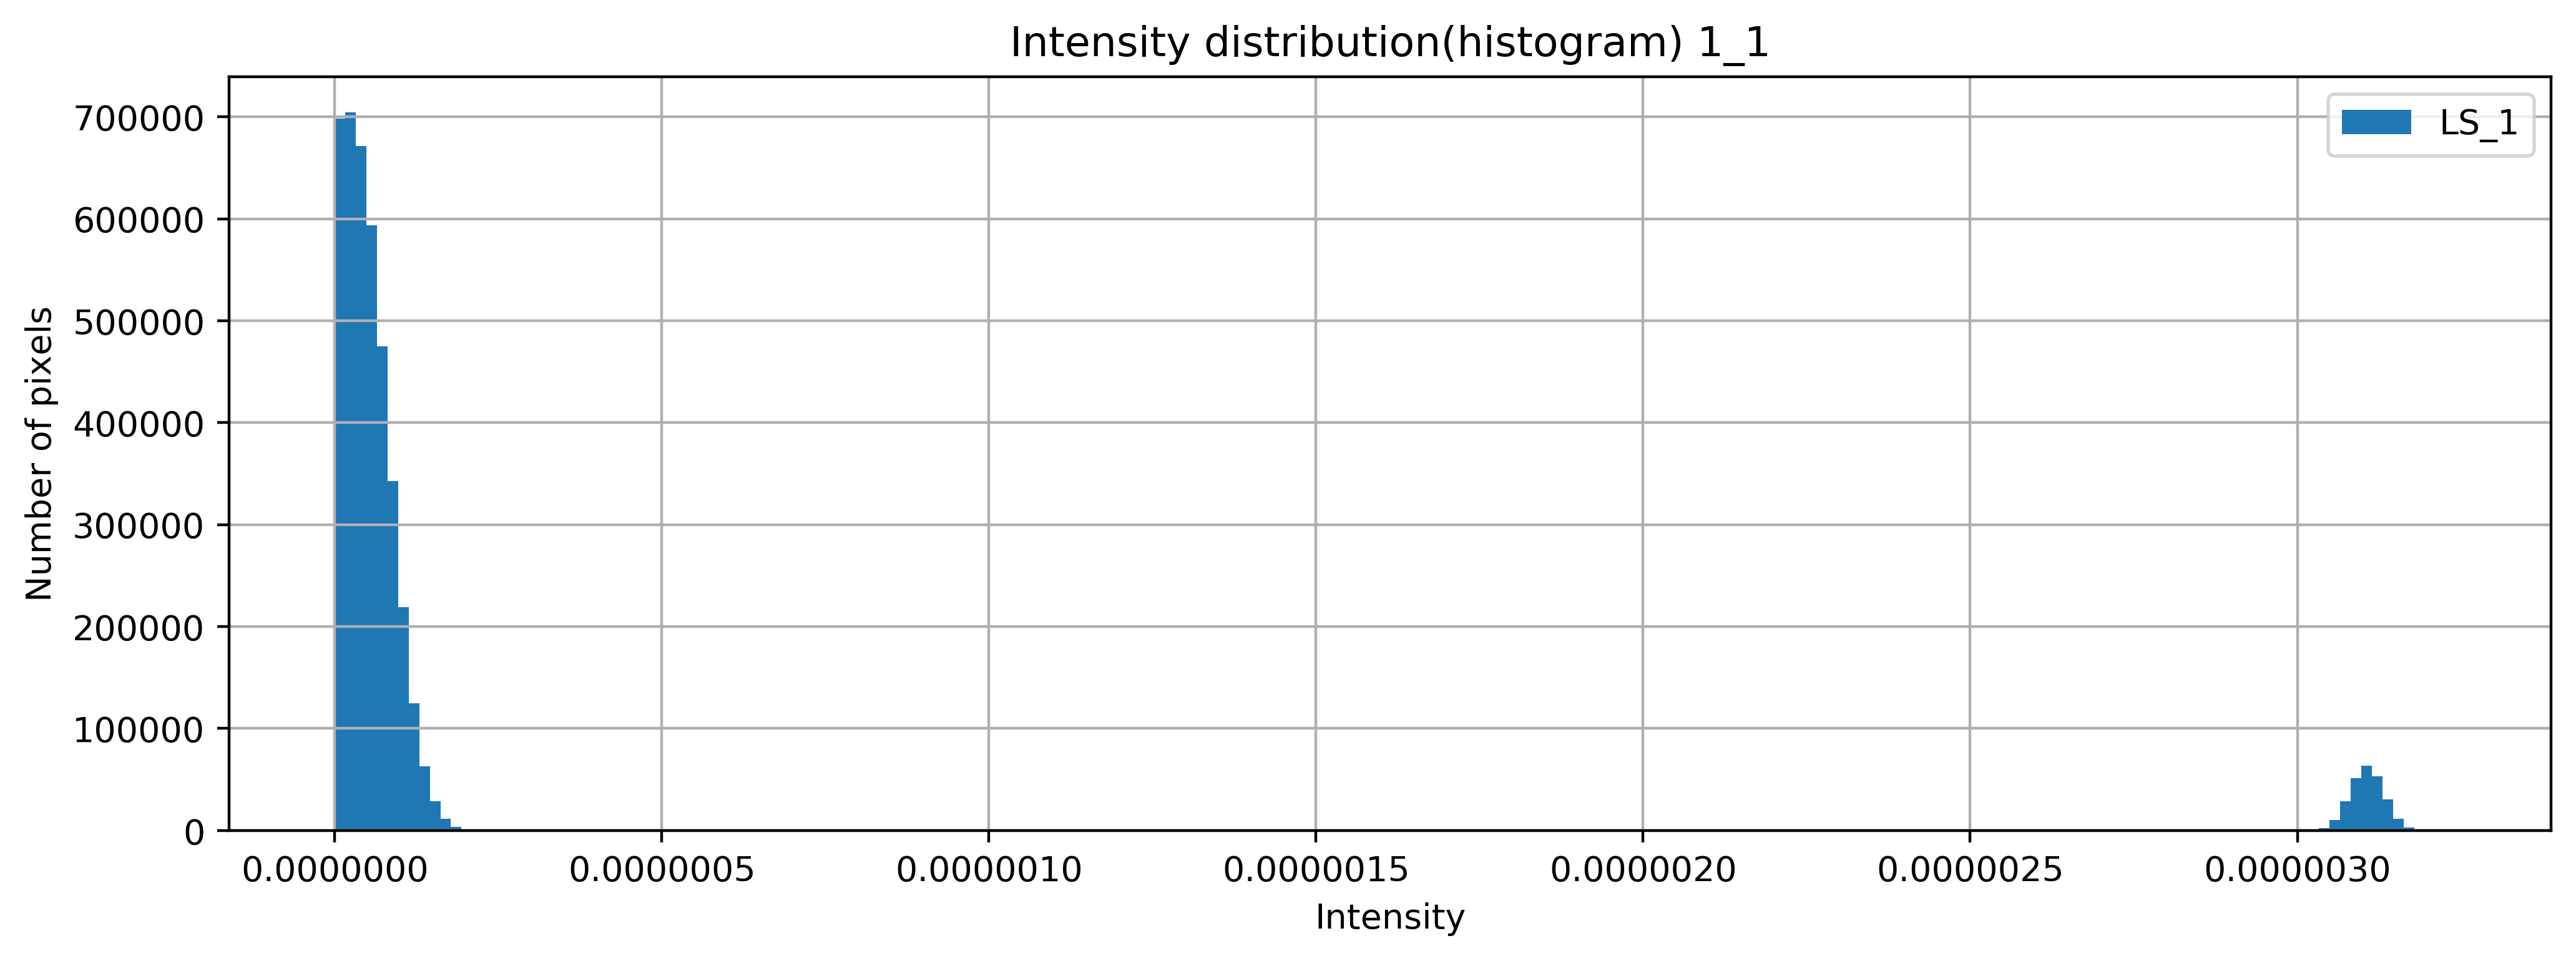

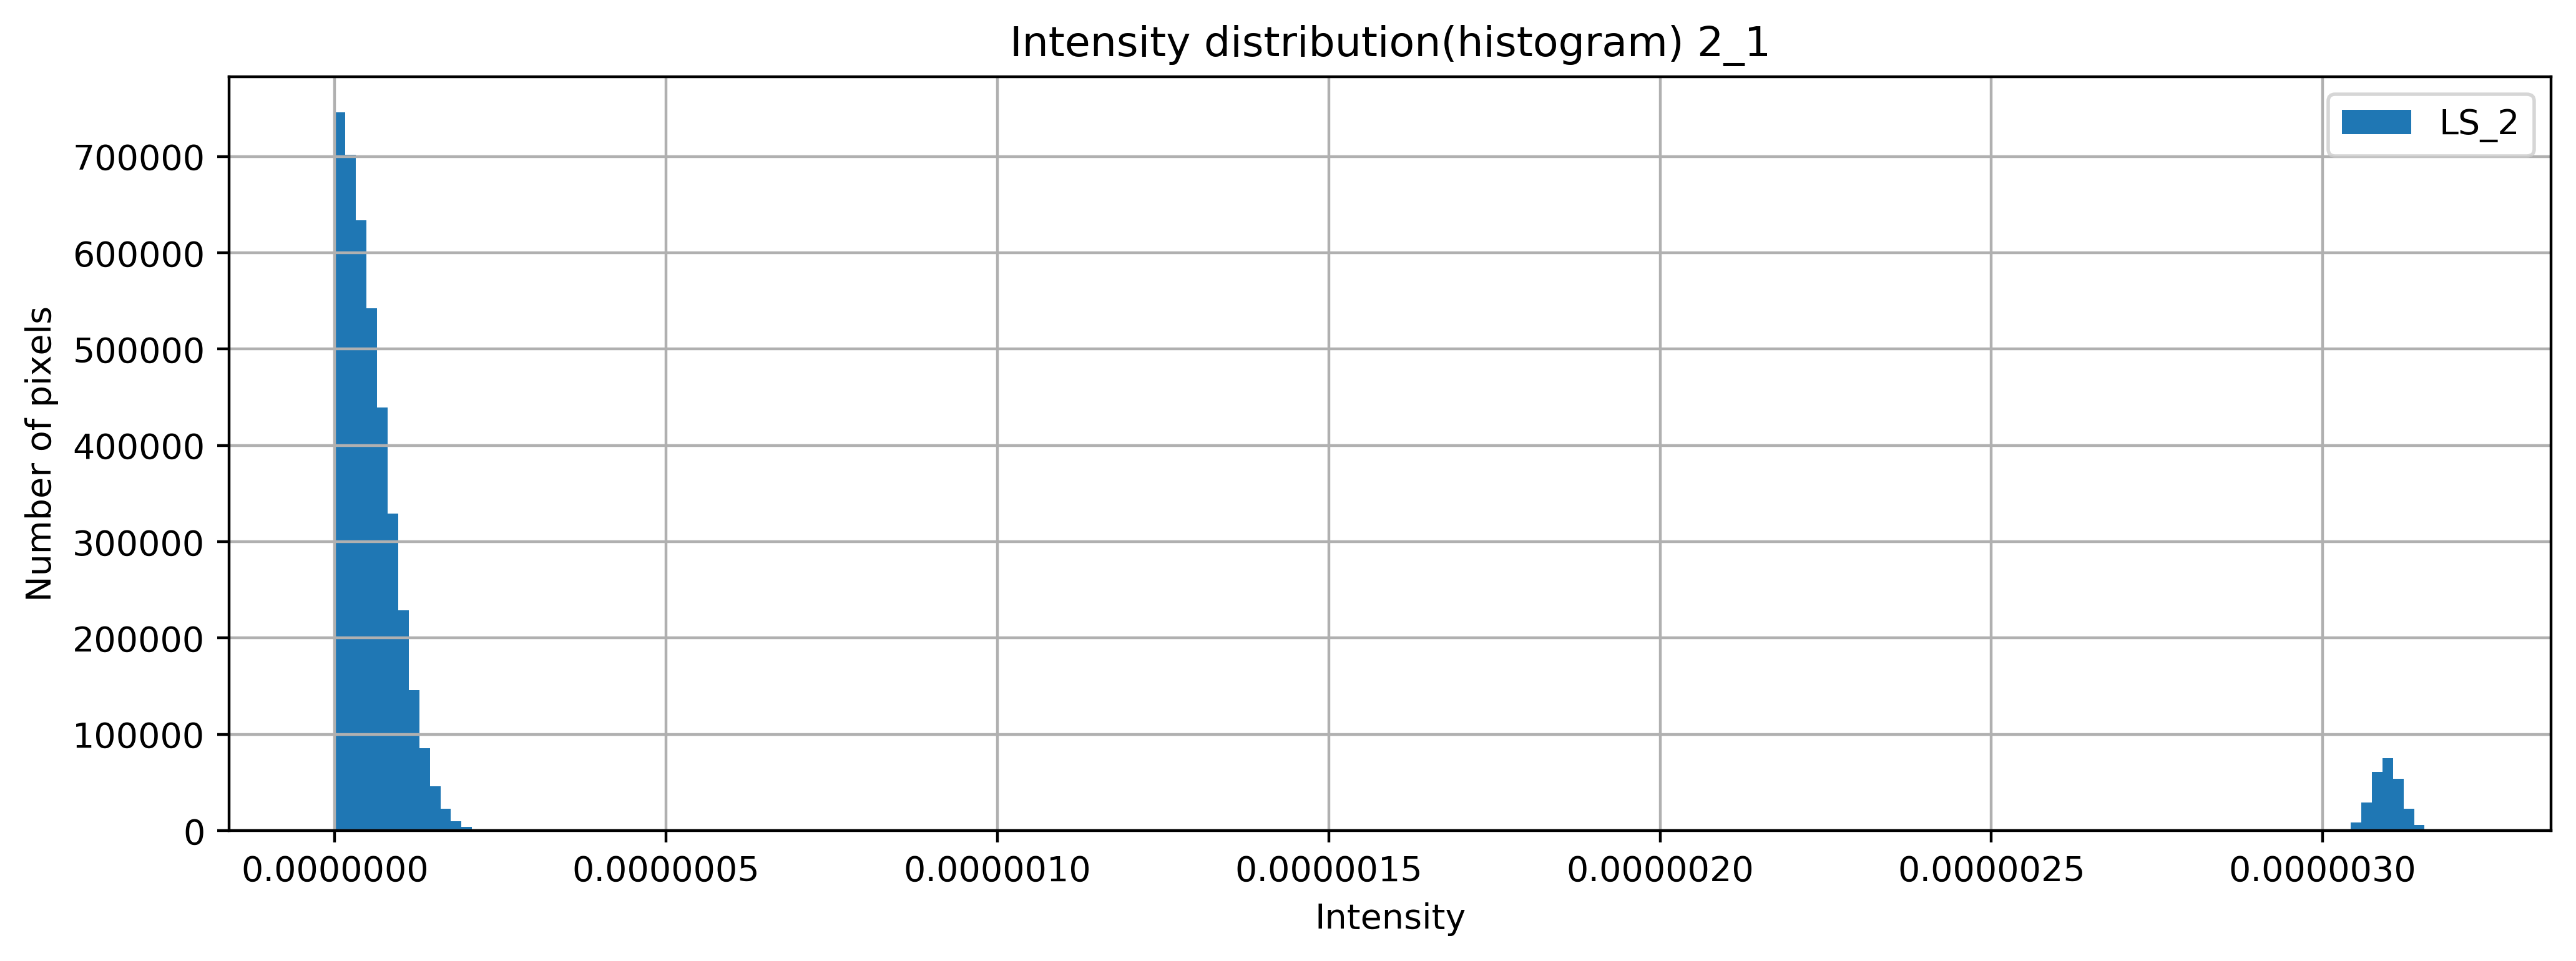

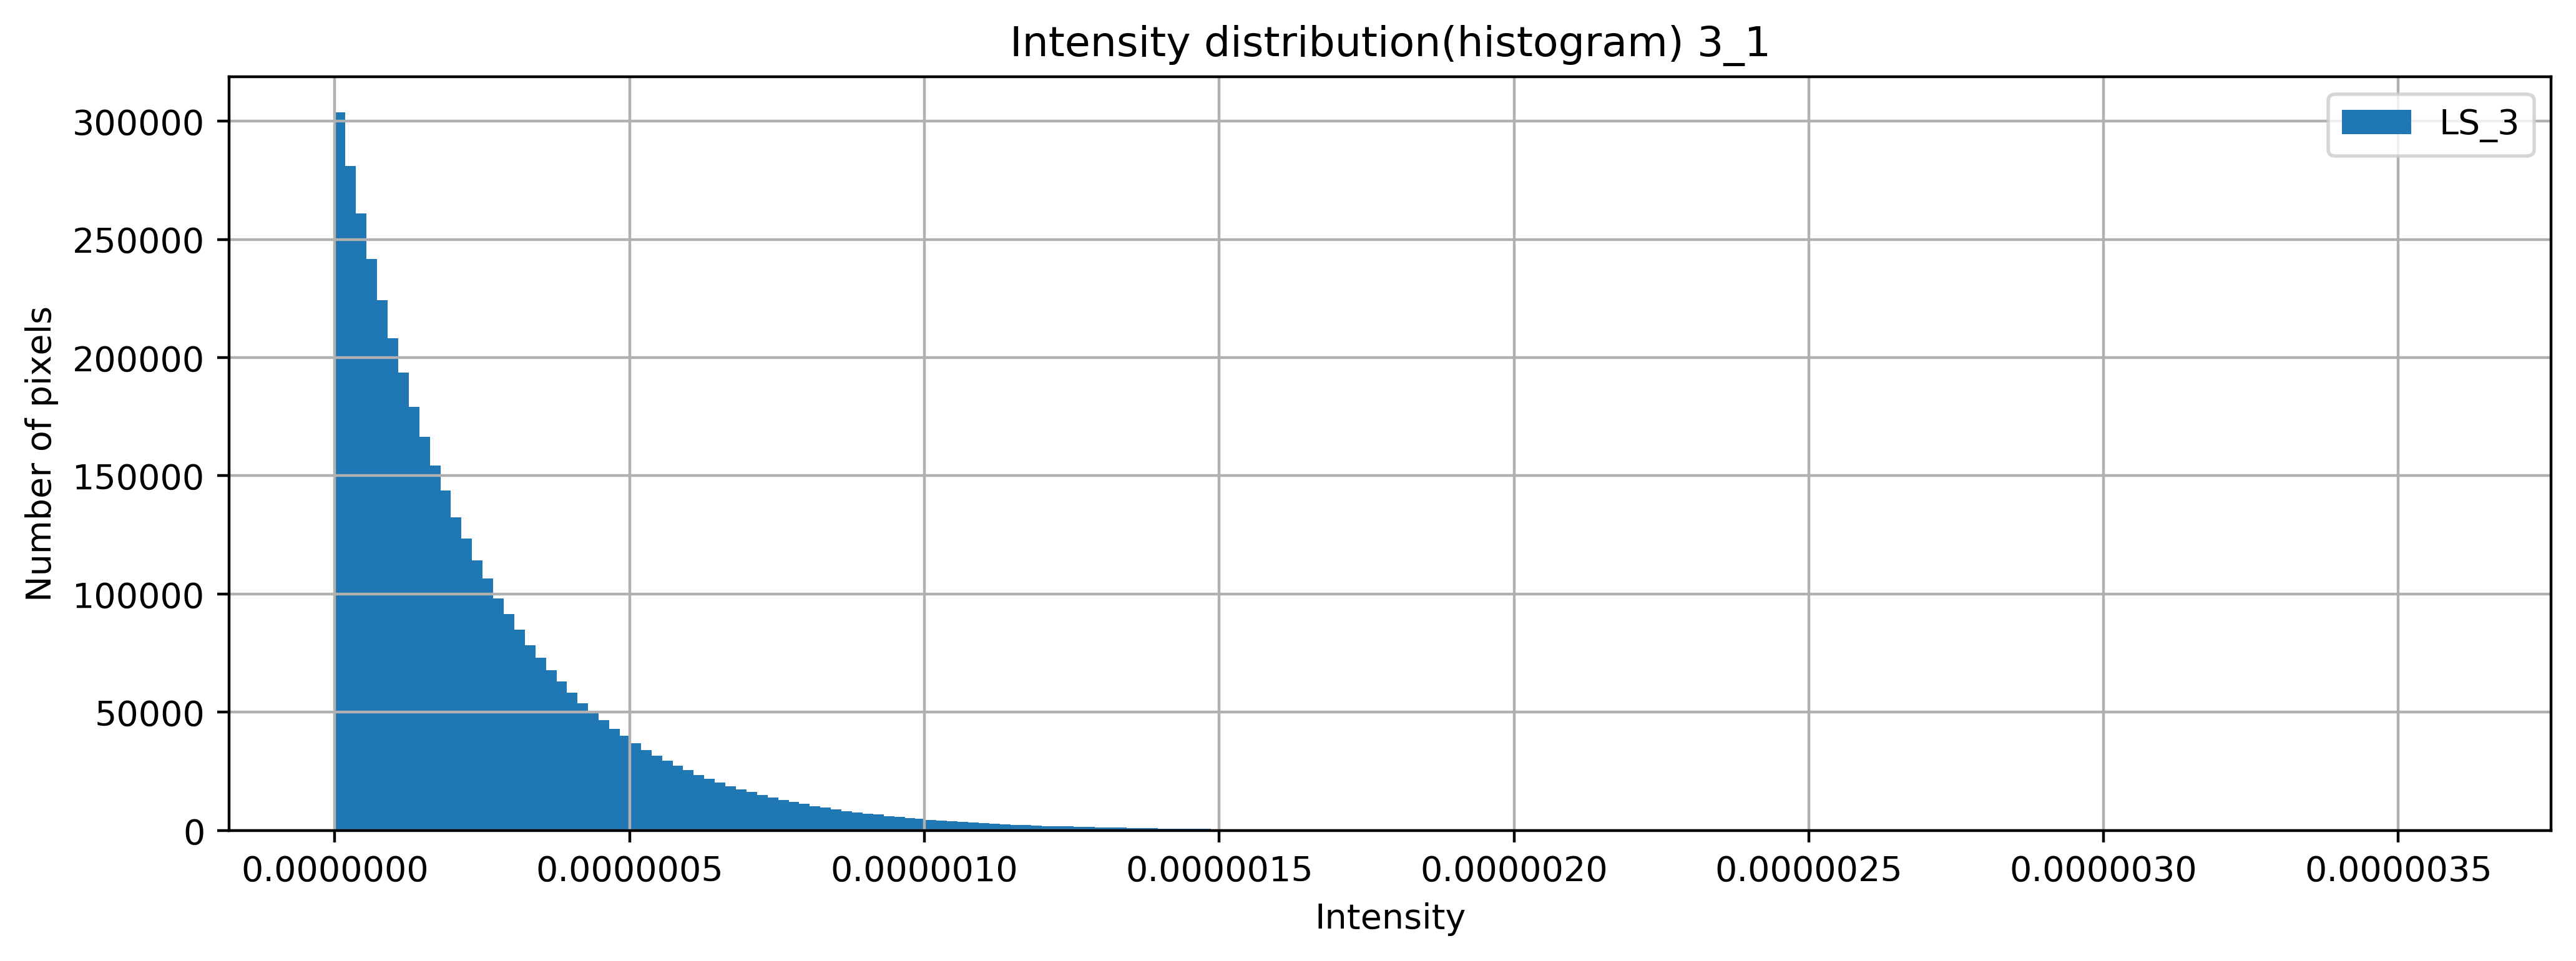

In [13]:
plt.figure(dpi=400, figsize=(12,4))
plt.hist(intensity_ls_1_1.flatten(),200,label='LS_1')
# plt.xlim(0,4e-07)
plt.title('Intensity distribution(histogram) 1_1')
plt.xlabel('Intensity')
plt.ylabel('Number of pixels')
plt.legend()
plt.grid()
plt.show()

plt.figure(dpi=400, figsize=(12,4))
plt.hist(intensity_ls_2_1.flatten(),200,label='LS_2')
# plt.xlim(0,4e-07)
plt.title('Intensity distribution(histogram) 2_1')
plt.xlabel('Intensity')
plt.ylabel('Number of pixels')
plt.legend()
plt.grid()
plt.show()

plt.figure(dpi=400, figsize=(12,4))
plt.hist(intensity_ls_3_1.flatten(),200,label='LS_3')
# plt.xlim(0,4e-07)
plt.title('Intensity distribution(histogram) 3_1')
plt.xlabel('Intensity')
plt.ylabel('Number of pixels')
plt.legend()
plt.grid()
plt.show()